In [2]:
!pip install torchviz

     |████████████████████████████████| 51kB 4.2MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3523 sha256=b9746b63b496f469593545d200c6103a96c5df44835e620f7cf34d94f8aeb735
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import torch
from torch import nn
from torchsummary import summary
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
from torch import optim
import numpy as np
from torchviz import make_dot
from scipy.io.arff import loadarff
import math
import os
import sys
import matplotlib.pyplot as plt
torch.manual_seed(0)
np.random.seed(0)
# curdir = "/content/"
# os.chdir('/content/drive/My Drive/xclib/')
# sys.path.append('/content/drive/My Drive/xclib')
# !python /content/drive/My\ Drive/xclib/setup.py install --user
# os.chdir(curdir)
# # print(curdir)
# !pwd
# import xclib.evaluation.xc_metrics as metric


In [7]:
!unrar x /content/drive/'My Drive'/mediamill.rar


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/drive/My Drive/mediamill.rar


Would you like to replace the existing file mediamill.arff
55708920 bytes, modified on 2007-02-28 17:51
with a new one
55708920 bytes, modified on 2007-02-28 17:51

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit A

Extracting  mediamill.arff                                                 0%  1%  2%  3%  4%  5%  6%  7%  8%  9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49%  OK 
Extracting  mediamill.xml                                                 49%  OK 
Extracting  mediamill-train.arff                                          50%

In [0]:
def get_data(path2):
  path = "/content"
  raw_data = loadarff(path+path2)
  df_data = pd.DataFrame(raw_data[0])
  X_cols = df_data.columns[:120]
  Y_cols = df_data.columns[120:]
  X_data = df_data[X_cols]
  Y_data = df_data[Y_cols]
  for col in Y_data.columns:
    Y_data[col] = Y_data[col].apply(lambda x: x.decode("utf-8"))
    Y_data[col] = Y_data[col].astype(int)
  return X_data.values, Y_data.values

In [0]:
train_path = "/mediamill-train.arff"
test_path = "/mediamill-test.arff"

In [10]:
X_train, Y_train = get_data(train_path)
X_test, Y_test = get_data(test_path)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [0]:
class XML(nn.Module):
    def calculateBowAndTfIdf(self, input):
        return self.bow.transform(input), self.tfidf.transform(input)
    
    def train(self, input):
        self.BoW = CountVectorizer(input)
        self.TfIdf = TfidfVectorizer(input)
    
    def __init__(self, input_size, embedding_size, attention_layer_size,
                 encoder_layer_size, hidden_layer_size, output_size, margin):
        self.m = margin
        ########## Feature Embedding
        ### Embedding Layer
        nn.Module.__init__(self)
        self.embedding = nn.Embedding(input_size, embedding_size)
        ### Attention Module
        self.attentionfc1 = nn.Linear( embedding_size,  attention_layer_size)
        self.attentionfc2 = nn.Linear(attention_layer_size, embedding_size)
        ### fully connected layer
        self.featurefc1 = nn.Linear(embedding_size, hidden_layer_size)
                                      
        ########## encoder
        self.encoderfc1 = nn.Linear(output_size, encoder_layer_size)
        self.encoderfc2 = nn.Linear(encoder_layer_size, hidden_layer_size)
        
        ########## decoder
        self.decoderfc1 = nn.Linear(hidden_layer_size, encoder_layer_size)
        self.decoderfc2 = nn.Linear(encoder_layer_size, output_size)
        
    def reconstructingLoss(self, y_predicted, y_actual):
        loss = 0
        for i in range(y_predicted.shape[0]):
          y_hat_n = y_predicted[i][y_actual[i]==0]
          y_hat_p = y_predicted[i][y_actual[i]==1]
          if(len(y_hat_p) == 0):
            continue
          y_p_min = torch.min(y_hat_p)
          y_n_max = torch.max(y_hat_n)
          loss1 = torch.sum(y_hat_n+self.m-y_p_min)
          loss1[loss1 < 0] = 0
          loss2 = torch.sum(-y_hat_p+self.m+y_n_max)
          loss2[loss2 < 0] = 0
          loss += (loss1+loss2)
        return loss
    
    def hiddenLoss(self, x_hidden, y_hidden):
        return torch.sum((x_hidden-y_hidden)**2)
      
    def train(self, X_train, Y_train, lr_=0.001, epochs=10, batch_size=256):
      X_data_new = np.array([list(range(X_train.shape[1]))]*X_train.shape[0])
      X_TfIdftensor =  torch.from_numpy(X_train)
      X_data_tensor =  torch.from_numpy(X_data_new)
      Y_data_tensor =  torch.from_numpy(Y_train)
      criterion = self.loss
      optimizer = optim.Adam(self.parameters(),lr=lr_)
      self.losses = []
      # epochs = 10
      # batch_size = 256 # or whatever
      for i,e in enumerate(range(epochs)):
          permutation = torch.randperm(X_data_tensor.size()[0])

          for j in range(0,X_data_tensor.size()[0], batch_size):
            indices = permutation[j:j+batch_size]
            optimizer.zero_grad()
            x_hidden, y_hidden, y_predicted = self.forward(X_data_tensor[indices], X_TfIdftensor[indices][:, :, None].type('torch.FloatTensor'), Y_data_tensor[indices].type('torch.FloatTensor'))
            loss = criterion(x_hidden, y_hidden, y_predicted, Y_data_tensor[indices].type('torch.FloatTensor'))
            loss.backward() # Backpropagation
            optimizer.step() # Optimizer one step
          print(f"Epoch - {i+1}, Loss - {round(loss.item(),3)}")  # Print loss
          self.losses.append(round(loss.item(),3))
      plt.plot(np.array(self.losses), 'r')

    def f_x(self, bow, tfidf):
        word_embedding = self.embedding(bow)
        #print("word_embedding_shape: ", word_embedding.shape)
        #print("tfidf:", tfidf.shape)
        word_embedding = tfidf * word_embedding
        #print("tfidf * word_embedding: ", word_embedding.shape)
        attention_embedding = word_embedding
        attention_embedding = torch.relu(self.attentionfc1(attention_embedding))
        #print("Attention after fc1: ", attention_embedding.shape)
        attention_embedding = torch.relu(self.attentionfc2(attention_embedding))
        #print("Attention after fc2: ", attention_embedding.shape)
        word_embedding = attention_embedding * word_embedding
        #print("Attention before pooling: ", word_embedding.shape)
        ###word_embedding - max pooling
        #print("word_embedding_shape: ", word_embedding.shape, " ", word_embedding.type())
        word_embedding = word_embedding.mean(1)
        #print("Attention after pooling: ", word_embedding.shape)
        x_hidden = torch.relu(self.featurefc1(word_embedding))
        return x_hidden
    
    def e_y(self, labels):
        y_hidden = torch.relu(self.encoderfc1(labels))
        y_hidden = torch.relu(self.encoderfc2(y_hidden))
        return y_hidden
    
    def d_y(self, y_hidden):
        y_predicted = torch.relu(self.decoderfc1(y_hidden))
        y_predicted = torch.sigmoid(self.decoderfc2(y_predicted))
        return y_predicted

    def forward(self, bow, tfidf, labels):
        x_hidden = self.f_x(bow, tfidf)
        y_hidden = self.e_y(labels)
        y_predicted = self.d_y(y_hidden)
        return x_hidden, y_hidden, y_predicted

    def predict(self, X_test):
        X_data_new = np.array([list(range(X_test.shape[1]))]*X_test.shape[0])
        tfidf =  torch.from_numpy(X_test)
        tfidf = tfidf[:, :, None].type('torch.FloatTensor')
        bow =  torch.from_numpy(X_data_new)
        x_hidden = self.f_x(bow, tfidf)
        y_predicted = self.d_y(x_hidden)
        return y_predicted.cpu().detach().numpy()

    def loss(self, x_hidden, y_hidden, y_predicted, y_actual, lamda = 1):
        loss_hidden = self.hiddenLoss(x_hidden, y_hidden)
        loss_ae = self.reconstructingLoss(y_predicted, y_actual)
        return loss_hidden+lamda*loss_ae
    

In [0]:
def p_k(y_predicted, y_actual, k):
  res = 0
  for i in range(len(y_predicted)):
    indices = y_predicted[i].argsort()[-k:][::-1]
    res += (y_actual[i][indices].sum())/k
  return res/len(y_predicted)

def dcg_k(y_predicted, y_actual, k):
  logger = lambda t: 1/math.log(1+t,2)
  logger = np.vectorize(logger)
  l = np.arange(1,1+y_predicted.shape[1])
  l = logger(l)
  res = np.zeros(y_predicted.shape[0])
  for i in range(len(y_predicted)):
    indices = y_predicted[i].argsort()[-k:][::-1]
    temp = l*y_actual[i]
    res[i] = temp[indices].sum()
  return res

def n_k(y_predicted, y_actual, k):
  dcg_k_list = dcg_k(y_predicted, y_actual, k)
  logger = lambda t: 1/math.log(1+t,2)
  logger = np.vectorize(logger)
  res = 0
  for i in range(len(y_predicted)):
    lim = y_actual[i].sum()
    if(lim == 0):
      continue
    l = np.arange(1,1+min(lim,k))
    l = logger(l)
    deno = l.sum()
    res += dcg_k_list[i]/deno
  return res/y_predicted.shape[0]

In [0]:
document = "Hey there delilah whats it like in new york city I am thousand miles away but tonight you look so pretty yes you do hey there delilah don't you worry about the distance I am right there if you get lonenly give this song another listen"

In [0]:
count_vec = CountVectorizer()
count_occurs = count_vec.fit_transform([document])
count_occur_df = pd.DataFrame(
    (count, word) for word, count in
     zip(count_occurs.toarray().tolist()[0], 
    count_vec.get_feature_names()))
count_occur_df.columns = ['Word', 'Count']
count_occur_df.sort_values('Count', ascending=False, inplace=True)
print(count_occur_df.shape)
count_occur_df.head()

(36, 2)


,Word,Count
35,you,4
27,there,3
6,delilah,2
12,hey,2
1,am,2


In [0]:
tfidf_vec = TfidfVectorizer()
tfidf_count_occurs = tfidf_vec.fit_transform([document])
tfidf_count_occur_df = pd.DataFrame(
    (count, word) for word, count in zip(
    tfidf_count_occurs.toarray().tolist()[0],   
    tfidf_vec.get_feature_names()))
tfidf_count_occur_df.columns = ['Word', 'Count']
tfidf_count_occur_df.sort_values('Count', ascending=False, inplace=True)
tfidf_count_occur_df.head()

,Word,Count
35,you,0.485071
27,there,0.363803
6,delilah,0.242536
12,hey,0.242536
1,am,0.242536


In [0]:
make_dot(y_hidden)

NameError: ignored

In [0]:
make_dot(y_predicted)

In [0]:
#@title
make_dot(x_hidden)

Epoch - 1, Loss - 1348.917
Epoch - 2, Loss - 1252.801
Epoch - 3, Loss - 542.919
Epoch - 4, Loss - 810.121
Epoch - 5, Loss - 475.033
Epoch - 6, Loss - 761.171
Epoch - 7, Loss - 343.515
Epoch - 8, Loss - 461.34
Epoch - 9, Loss - 431.255
Epoch - 10, Loss - 668.105
Epoch - 11, Loss - 450.011
Epoch - 12, Loss - 319.28
Epoch - 13, Loss - 156.571
Epoch - 14, Loss - 413.498
Epoch - 15, Loss - 280.238
Epoch - 16, Loss - 242.657
Epoch - 17, Loss - 111.784
Epoch - 18, Loss - 224.245
Epoch - 19, Loss - 117.202
Epoch - 20, Loss - 121.862
Epoch - 21, Loss - 223.228
Epoch - 22, Loss - 228.869
Epoch - 23, Loss - 178.638
Epoch - 24, Loss - 132.442
Epoch - 25, Loss - 284.407
Epoch - 26, Loss - 149.477
Epoch - 27, Loss - 306.115
Epoch - 28, Loss - 191.764
Epoch - 29, Loss - 281.641
Epoch - 30, Loss - 270.034
Epoch - 31, Loss - 105.414
Epoch - 32, Loss - 77.06
Epoch - 33, Loss - 187.918
Epoch - 34, Loss - 91.592
Epoch - 35, Loss - 216.361
Epoch - 36, Loss - 80.201
Epoch - 37, Loss - 256.812
Epoch - 38, Lo

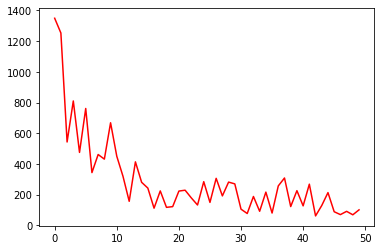

In [13]:
model = XML(input_size=X_train.shape[1], embedding_size=100, attention_layer_size=50,
                encoder_layer_size=80, hidden_layer_size=50,output_size=Y_train.shape[1], margin=0.8)
model.train(X_train, Y_train, lr_ = 0.0001, epochs=50, batch_size=256)

In [1]:
y_pred = model.predict(X_test)

NameError: ignored

In [22]:
print("P@1: ",p_k(y_pred, Y_test, 1))
print("P@3: ",p_k(y_pred, Y_test, 3))
print("P@5: ",p_k(y_pred, Y_test, 5))

P@1:  0.7587114759176088
P@3:  0.6253678178721078
P@5:  0.4806721387641224


In [23]:
print("n@1: ",n_k(y_pred, Y_test, 1))
print("n@3: ",n_k(y_pred, Y_test, 3))
print("n@5: ",n_k(y_pred, Y_test, 5))

n@1:  0.12420535945891828
n@3:  0.15980616758948912
n@5:  0.16808379148900368


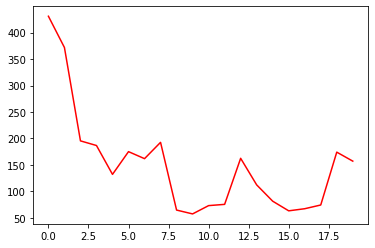

In [28]:
plt.plot(np.array(model.losses), 'r')